In [1]:
import time

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

from tqdm import tqdm
import matplotlib.pyplot as plt

from model import Encoder, Decoder, Seq2Seq
from dataset import BluesPairSet

In [2]:
import pickle


def load_loss(date, num):
    try:
        with open(f"models/blues_call_and_res_model-loss-{date}-{num}.p", 'rb') as f: 
            return pickle.load(f)
    except FileNotFoundError:
        return {}


def save_loss(date, num, loss_obj): # loss obj = { train_loss, valid_loss }
    with open(f"models/blues_call_and_res_model-loss-{date}-{num}.p", 'wb') as f:
        pickle.dump(loss_obj, f)

In [3]:
dataset = BluesPairSet()

100%|██████████| 104/104 [00:10<00:00,  9.87it/s]


In [4]:

class Trainer:
    def __init__(self, model, optimizer, loss_fn, train_loader, valid_loader, device='cpu'):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        
        self.device = device
        self.model.to(self.device)
        
        self.best_valid_accuracy = 0
        
        self.training_loss = []
        self.validation_loss = []
        self.validation_acc = []

    def save_model(self, path='models/', surfix=''):
        model_default_name = 'blues_call_and_res_model-'
        torch.save({'model':self.model.state_dict(), 'optim':self.optimizer.state_dict()}, f'{path}{model_default_name}{int(time.time())}{surfix}')
        
    def _get_accuracy(self, pred, target_sqz):
        # pred: [batch size * pred len, num vocab]
        # target_sqz: [batch size * target len]
        
        is_correct = pred.argmax(dim=-1) == target_sqz
        return (is_correct.sum() / target_sqz.reshape(-1,).shape[-1]).item()
        
    def train_by_num_epoch(self, num_epochs, tfr=0.5, do_validate=False): # tfr: teacher forcing ratio
        for epoch in tqdm(range(num_epochs)):
            self.model.train()
            
            for batch in self.train_loader:
                loss_value = self._train_by_single_batch(batch, tfr=tfr)
                self.training_loss.append(loss_value)
            
            if do_validate:
                self.model.eval()
                
                validation_loss, validation_acc = self.validate()
                self.validation_loss.append(validation_loss)
                self.validation_acc.append(validation_acc)
                
                if validation_acc > self.best_valid_accuracy:
                    print(f"Saving the model with best validation accuracy: Epoch {epoch+1}, Acc: {validation_acc:.4f} ")
                    self.save_model()
                # else:
                #     self.save_model()
                    
                self.best_valid_accuracy = max(validation_acc, self.best_valid_accuracy)

        
    def _train_by_single_batch(self, batch, tfr=0.5):
        self.model.train()

        call, res = batch
        output = self.model(call, res, teacher_forcing_ratio=tfr) # [target len, batch size, target vocab size]
        
        output = output.permute(1, 0, 2).contiguous() # [batch size, target len, target vocab size]
        vocab_size = output.shape[-1]
        
        output = output.softmax(dim=-1)
        
        res = res[:, 1:].contiguous().view(-1)
        output = output.view(-1, vocab_size)
        
        loss = self.loss_fn(output, res)
        
        self.optimizer.zero_grad()
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()


    def validate(self, external_loader=None):
        
        if external_loader and isinstance(external_loader, DataLoader):
            loader = external_loader
            print('An arbitrary loader is used instead of Validation loader')
        else:
            loader = self.valid_loader
        
        self.model.eval()
        
        with torch.no_grad():
            valid_loss = 0
            valid_acc = 0
            batch_cnt = 0
            
            for batch in loader:
                call, res = batch
                
                output = self.model(call, res, teacher_forcing_ratio=0) # [target len, batch size, target vocab size]
                
                output = output.permute(1, 0, 2).contiguous() # [batch size, target len, target vocab size]
                vocab_size = output.shape[-1]
                
                output = output.softmax(dim=-1)
                
                res = res[:, 1:].contiguous().view(-1)
                output = output.view(-1, vocab_size)
                
                loss = self.loss_fn(output, res)
                
                valid_loss += loss.item()
                valid_acc += self._get_accuracy(output, res)
                
                batch_cnt += 1
                
            valid_loss /= batch_cnt
            valid_acc /= batch_cnt
                
            return valid_loss, valid_acc

In [5]:
EMB_LEN = dataset.vocab_size
EMB_DIM = 64
HID_DIM = 256
NUM_LAYER = 3
PAD_IDX = dataset.token2idx['<pad>']

encoder = Encoder(EMB_LEN, EMB_DIM, HID_DIM, num_layers=NUM_LAYER) # input size(embed len), embed size, hidden size
decoder = Decoder(EMB_LEN, EMB_DIM, HID_DIM, num_layers=NUM_LAYER) # output size(embed len), embed size, hidden size

model = Seq2Seq(encoder, decoder)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [6]:
trainset, validset = torch.utils.data.random_split(dataset, [42, 10])
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
valid_loader= torch.utils.data.DataLoader(validset, batch_size=10, shuffle=False)

In [7]:
trainer = Trainer(model, optimizer, loss_fn, train_loader, valid_loader)


In [9]:
NUM_EPOCH = 100

--------------------------------------------------------------------
# no adjusting above

In [31]:
trainer.train_by_num_epoch(NUM_EPOCH, tfr=1.0, do_validate=True)

100%|██████████| 100/100 [03:05<00:00,  1.86s/it]


In [32]:
num_iter = 6
total_calc = 3 * NUM_EPOCH * num_iter

train_loss = trainer.training_loss
valid_loss = trainer.validation_loss

trainer.save_model(surfix=f'-{total_calc}')
save_loss('230329', f'001', { 'train_loss': train_loss, 'valid_loss': valid_loss })

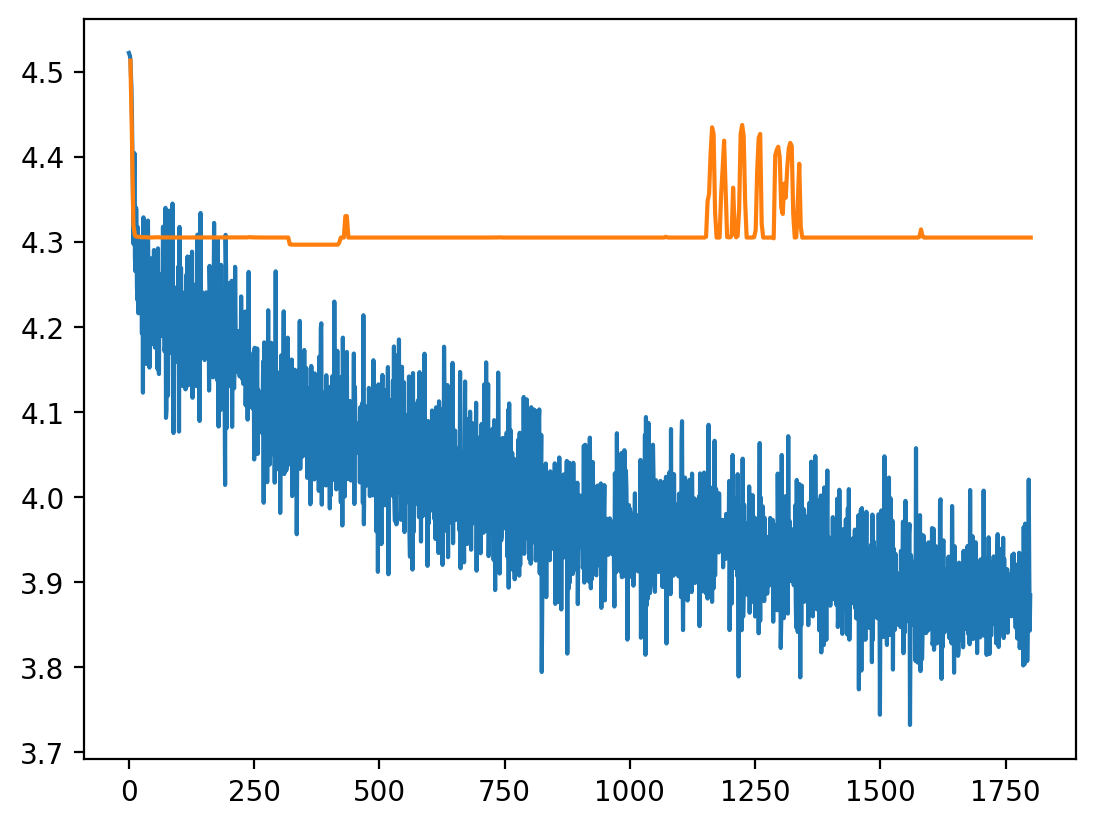

In [33]:
plt.plot(train_loss)
plt.plot(list(range(3, total_calc + 3, 3)), valid_loss)

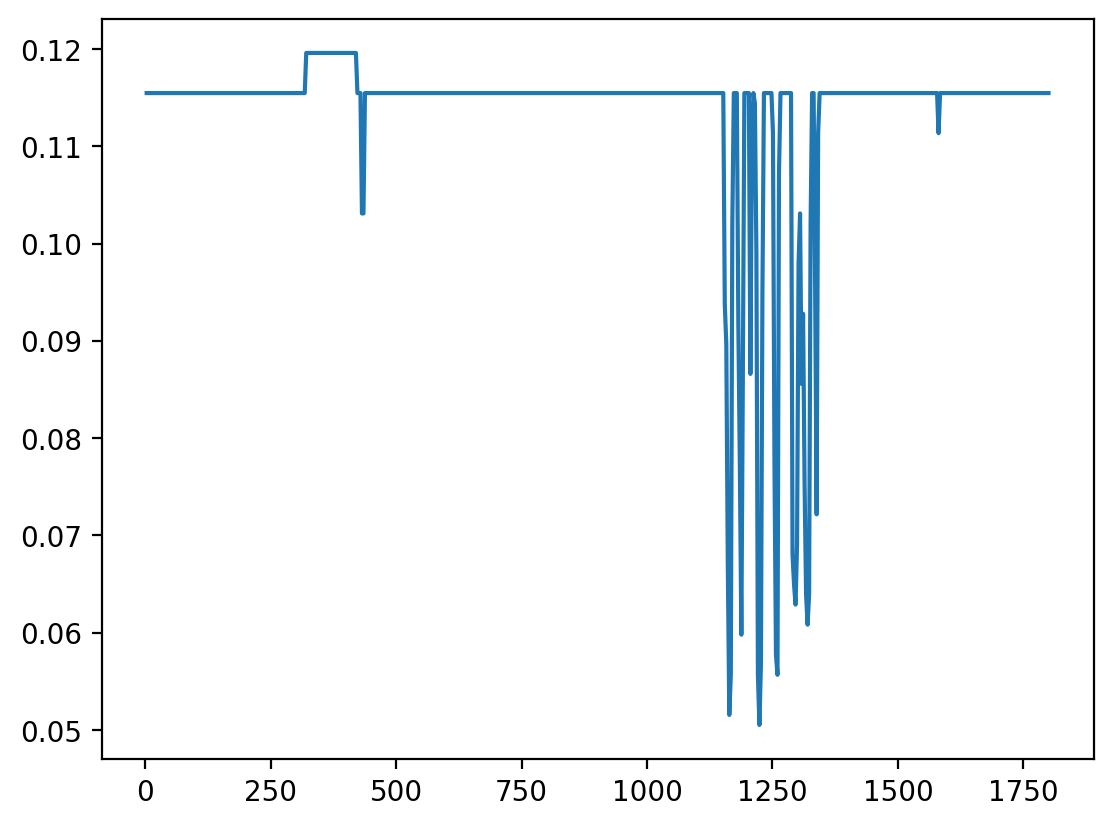

In [34]:
plt.plot(list(range(3, total_calc + 3, 3)), trainer.validation_acc)